# Markov Transitions Roberta Base SST2

In [1]:
# model_id = "textattack/roberta-base-MNLI"
model_id = "JeremiahZ/roberta-base-sst2"

In [2]:
# install dependencies

! pip install -q joblib  # joblib for memoizing functions
! pip install -q ipywidgets widgetsnbextension pandas-profiling # IProgress for progress bars

# ! pip install -q tensorflow==2.13.0 tensorflow-datasets==4.9.2 tensorflow-probability==0.21.0 transformers==4.35.0  datasets==2.14.6 torch==2.1.0 scipy==1.10.1 scikit-learn==1.3.2

In [3]:
# Add model_merging to the python path

import os
import sys

model_merging_base = os.path.abspath("../model_merging/")
# assert it exist
assert os.path.exists(model_merging_base)
if model_merging_base not in sys.path:
    sys.path.append(model_merging_base)

In [4]:
# import joblib for caching and distributed computing
from math import sqrt

from joblib import Memory, Parallel, delayed

memory = Memory(location="cache", verbose=10)

parallel = Parallel(n_jobs=2, return_as="generator")
output_generator = parallel(delayed(sqrt)(i**2) for i in range(10))

In [5]:
# Imports and cached functions

import os

from llm_weaver import (
    calculate_score_from_weaving_config,
    test_weaver,
)

# Disable parallelism in tokenizers to avoid deadlocks
os.environ["TOKENIZERS_PARALLELISM"] = "false"

calculate_score_from_weaving_config_cached = memory.cache(
    calculate_score_from_weaving_config
)
test_weaver_cached = memory.cache(test_weaver)

## Step 0: Test weaving code

This test makes sure that our score when using the weaver to reconstruct a model from all its parts get the same evaluation score as the original model

## Steps: configs to graph


In [17]:
from llm_weaver import dict_overwrite, get_model_config, normalize_glue_task_name


def transitions_weave_configs_iter(model_id, trajectories=None, max_configs=None):
    num_original_layers = get_model_config(model_id)["num_hidden_layers"]

    if trajectories is None:
        x_y_layer_sequences = [
            (x, y, (list(range(0, x + 1)) + list(range(y, num_original_layers))))
            for x in range(num_original_layers)
            for y in range(num_original_layers)
        ]
    else:
        x_y_layer_sequences = [(None, None, trajectory) for trajectory in trajectories]

    if max_configs is not None:
        x_y_layer_sequences = x_y_layer_sequences[:max_configs]
    for x, y, layer_sequence in x_y_layer_sequences:
        layer_assignments = [
            {
                "type": "SingleLayer",
                "params": {
                    "donor": model_id,
                    "hidden_layer_number": i,
                },
            }
            for i in layer_sequence
        ]

        blank_model_config = dict_overwrite(
            get_model_config(model_id),
            {
                "num_hidden_layers": len(layer_assignments),
            },
        )
        config = {
            "glue_task": normalize_glue_task_name(model_id),
            "tokenizer_model_id": model_id,
            "blank_model_config": blank_model_config,
            "layer_assignments": layer_assignments,
            "classification_head": {
                "type": "SingleClassificationHead",
                "params": {
                    "donor": model_id,
                },
            },
            "embeddings": {
                "type": "SingleEmbeddings",
                "params": {
                    "donor": model_id,
                },
            },
            "metadata": {
                "x": x,
                "y": y,
            },
        }

        yield config


weave_configs = list(
    transitions_weave_configs_iter(
        model_id=model_id,
    )
)


len(weave_configs)

144

In [18]:
import pandas as pd

scores = Parallel(n_jobs=5, return_as="list")(
    delayed(calculate_score_from_weaving_config_cached)(
        weave_config,
        # n_examples=4096,
        n_examples=128,
        split="train",
    )
    for weave_config in weave_configs
)
accuracies = [score["accuracy"] for score in scores]


records = []
for weave_config, accuracy in zip(weave_configs, accuracies):
    record = weave_config["metadata"]
    record["accuracy"] = accuracy
    records.append(record)
df_big_grid_train = pd.DataFrame.from_records(records)

________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')
calculating score for weaving config md5sum: 9d9469d5257bd701db2c01cdeb4f5ad9
__

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Some weights of the PyTorch model were not used when initializing the TF 2.0 mode

2023-11-28 13:39:55.868333: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 13:39:58.079037: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 13:39:58.974101: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

_____________________________calculate_score_from_weaving_config - 22.5s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 27.2s, 0.5min
Loading JeremiahZ/roberta-base-sst2
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')
calculating score for weaving config md5sum: b99b934328385e23ac48fe41e86f6c19
Lo

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')
calculating score for weaving config md5sum: f419563bab6dc66d249131116729abbc


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


2023-11-28 13:40:14.148611: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2023-11-28 13:40:17.321277: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2023-11-28 13:40:18.317001: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 13:40:18.359402: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 13:40:18.364925: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

_____________________________calculate_score_from_weaving_config - 16.6s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 12.6s, 0.2min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 14.9s, 0.2min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

2023-11-28 13:40:25.004727: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:40:26.35

______________________________calculate_score_from_weaving_config - 5.9s, 0.1min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


______________________________calculate_score_from_weaving_config - 5.4s, 0.1min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:40:37.42

_____________________________calculate_score_from_weaving_config - 23.9s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 28.2s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-11-28 13:40:57.774896: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 13:41:00.390210: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 13:41:00.837293: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

_____________________________calculate_score_from_weaving_config - 12.6s, 0.2min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 16.5s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

2023-11-28 13:41:10.145491: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


2023-11-28 13:41:11.476634: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


______________________________calculate_score_from_weaving_config - 6.1s, 0.1min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
______________________________calculate_score_from_weaving_config - 9.9s, 0.2min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:41:24.190683: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 13:41:25.976413: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] Th

_____________________________calculate_score_from_weaving_config - 31.7s, 0.5min
_____________________________calculate_score_from_weaving_config - 28.9s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                    

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 25.8s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')
calculating score for weaving config md5sum: b6dee44f7ddc6c41f60e26fda8c64f53


2023-11-28 13:41:47.748349: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Loading JeremiahZ/roberta-base-sst2


2023-11-28 13:41:49.728769: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 13:41:49.808969: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 13:41:50.377112: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

_____________________________calculate_score_from_weaving_config - 12.6s, 0.2min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/model_merging/model_merging/evaluation.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  return hfds.load_metric("glue", task)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 16.8s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 20.2s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

2023-11-28 13:41:58.779736: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2


2023-11-28 13:42:00.959652: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 15.0s, 0.3min


2023-11-28 13:42:02.640404: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')
calculating score for weaving config md5sum: 93d0fc088863febbb22c018cd5785f80


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 11.4s, 0.2min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:42:15.07

_____________________________calculate_score_from_weaving_config - 32.6s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 27.8s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 31.4s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 16.7s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 20.0s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:42:57.15

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:42:58.926865: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


______________________________calculate_score_from_weaving_config - 9.8s, 0.2min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:43:10.733722: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 13:43:11.787916: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] Th

_____________________________calculate_score_from_weaving_config - 31.9s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 30.3s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:43:40.07

_____________________________calculate_score_from_weaving_config - 21.6s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 25.6s, 0.4min
_____________________________calculate_score_from_weaving_config - 19.6s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                    

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:43:56.794370: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/tr

_____________________________calculate_score_from_weaving_config - 13.9s, 0.2min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:44:11.61

_____________________________calculate_score_from_weaving_config - 34.9s, 0.6min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 32.3s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:44:42.14

_____________________________calculate_score_from_weaving_config - 25.3s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 20.3s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 22.3s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-11-28 13:45:02.852317: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


_____________________________calculate_score_from_weaving_config - 13.3s, 0.2min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:45:16.39

_____________________________calculate_score_from_weaving_config - 37.1s, 0.6min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 34.4s, 0.6min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:45:49.61

_____________________________calculate_score_from_weaving_config - 27.1s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 22.4s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


2023-11-28 13:46:10.510403: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:46:12.538000: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] Th

_____________________________calculate_score_from_weaving_config - 15.3s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:46:26.232653: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 13:46:27.815810: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] Th

_____________________________calculate_score_from_weaving_config - 40.3s, 0.7min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 35.1s, 0.6min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:47:00.636243: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 13:47:02.698410: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] Th

_____________________________calculate_score_from_weaving_config - 26.5s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 26.0s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 24.5s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


2023-11-28 13:47:23.382014: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/tr

_____________________________calculate_score_from_weaving_config - 19.7s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:47:40.387489: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 13:47:42.526909: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] Th

_____________________________calculate_score_from_weaving_config - 43.6s, 0.7min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 37.5s, 0.6min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:48:17.67

_____________________________calculate_score_from_weaving_config - 29.2s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 34.4s, 0.6min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 28.0s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2


2023-11-28 13:48:42.362785: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/tr

_____________________________calculate_score_from_weaving_config - 22.0s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

2023-11-28 13:48:58.067928: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/tr

_____________________________calculate_score_from_weaving_config - 43.9s, 0.7min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

2023-11-28 13:49:17.737815: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 13:49:18.292373: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


_____________________________calculate_score_from_weaving_config - 41.7s, 0.7min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 38.1s, 0.6min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:49:38.116176: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/tr

_____________________________calculate_score_from_weaving_config - 35.0s, 0.6min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 27.2s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

2023-11-28 13:50:06.677136: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/tr

_____________________________calculate_score_from_weaving_config - 24.3s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

2023-11-28 13:50:21.231001: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:50:28.35

_____________________________calculate_score_from_weaving_config - 47.7s, 0.8min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

2023-11-28 13:50:43.828107: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 13:50:46.121243: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 46.4s, 0.8min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 43.7s, 0.7min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:51:06.493819: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/tr

_____________________________calculate_score_from_weaving_config - 40.2s, 0.7min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 30.3s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 33.0s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

2023-11-28 13:51:38.067244: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/tr

_____________________________calculate_score_from_weaving_config - 26.4s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

2023-11-28 13:51:54.654346: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:52:02.32

_____________________________calculate_score_from_weaving_config - 49.8s, 0.8min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

2023-11-28 13:52:16.291121: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Loading JeremiahZ/roberta-base-sst2


2023-11-28 13:52:20.569668: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


_____________________________calculate_score_from_weaving_config - 48.8s, 0.8min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 50.5s, 0.8min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 44.3s, 0.7min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


2023-11-28 13:52:39.848085: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 13:52:45.735535: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] Th

_____________________________calculate_score_from_weaving_config - 40.4s, 0.7min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='train')

2023-11-28 13:52:57.726499: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 38.4s, 0.6min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 40.1s, 0.7min
Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 35.4s, 0.6min
_____________________________calculate_score_from_weaving_config - 31.9s, 0.5min


2023-11-28 13:53:11.351687: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 13:53:14.529074: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


_____________________________calculate_score_from_weaving_config - 20.6s, 0.3min
_____________________________calculate_score_from_weaving_config - 17.3s, 0.3min


In [19]:
df_big_grid_train

,x,y,accuracy
0,0,0,0.492188
1,0,1,0.750000
2,0,2,0.750000
3,0,3,0.671875
4,0,4,0.578125
...,...,...,...
139,11,7,0.679688
140,11,8,0.703125
141,11,9,0.664062
142,11,10,0.726562


<Axes: xlabel='y', ylabel='x'>

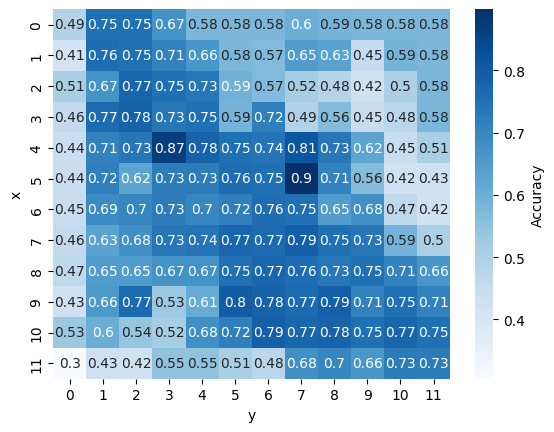

In [20]:
# Plot a heatmap of the accuracy with respect to the layer transitions
# x and y are the layer numbers of the first and last layer of the transition
# the color is the accuracy

import seaborn as sns

sns.heatmap(
    df_big_grid_train.pivot(index="x", columns="y", values="accuracy"),
    annot=True,
    # fmt=".0%",
    # do not show numbers in the heatmap
    # fmt=".0f",
    cmap="Blues",
    cbar_kws={"label": "Accuracy"},
)

In [7]:
import pandas as pd

scores = Parallel(n_jobs=5, return_as="list")(
    delayed(calculate_score_from_weaving_config_cached)(
        weave_config,
        # n_examples=4096,
        n_examples=128,
        split="validation",
    )
    for weave_config in weave_configs
)
accuracies = [score["accuracy"] for score in scores]


records = []
for weave_config, accuracy in zip(weave_configs, accuracies):
    record = weave_config["metadata"]
    record["accuracy"] = accuracy
    records.append(record)
df_big_grid = pd.DataFrame.from_records(records)

________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validation')
___________________________________________________________________________

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Some weights of the PyTorch model were not used when initializing the TF 2.0 mode

_____________________________calculate_score_from_weaving_config - 22.7s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 27.5s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 28.9s, 0.5min
Loading JeremiahZ/roberta-base-sst2
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 30.4s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


2023-11-28 10:34:40.798053: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2023-11-28 10:34:43.546648: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2023-11-28 10:34:44.452855: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 10:34:44.774426: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 10:34:45.185052: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

_____________________________calculate_score_from_weaving_config - 16.5s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 15.9s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2Loading JeremiahZ/roberta-base-sst2

Loading JeremiahZ/roberta-base-sst2


2023-11-28 10:34:51.489457: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

______________________________calculate_score_from_weaving_config - 5.5s, 0.1min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

2023-11-28 10:34:52.692082: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


______________________________calculate_score_from_weaving_config - 5.3s, 0.1min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:35:03.73

_____________________________calculate_score_from_weaving_config - 24.5s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 29.2s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-11-28 10:35:24.884732: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 10:35:26.064689: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 10:35:26.546333: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

_____________________________calculate_score_from_weaving_config - 11.8s, 0.2min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 16.0s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 17.5s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

2023-11-28 10:35:35.697052: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:35:37.27

______________________________calculate_score_from_weaving_config - 7.3s, 0.1min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:35:49.40

_____________________________calculate_score_from_weaving_config - 27.1s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-11-28 10:36:12.726382: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 10:36:14.352076: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 10:36:14.712907: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

_____________________________calculate_score_from_weaving_config - 12.5s, 0.2min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 16.3s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 20.0s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

2023-11-28 10:36:25.154990: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 10.3s, 0.2min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:36:40.807053: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 10:36:42.051402: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] Th

_____________________________calculate_score_from_weaving_config - 29.6s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 29.5s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 15.9s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 19.9s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


2023-11-28 10:37:20.669287: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/tr

_____________________________calculate_score_from_weaving_config - 10.0s, 0.2min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:37:34.571813: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 10:37:35.730446: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] Th

_____________________________calculate_score_from_weaving_config - 32.2s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 29.8s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:38:02.98

_____________________________calculate_score_from_weaving_config - 20.8s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 26.2s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:38:19.708938: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/tr

_____________________________calculate_score_from_weaving_config - 13.8s, 0.2min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:38:34.13

_____________________________calculate_score_from_weaving_config - 32.5s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 32.5s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:39:04.11

_____________________________calculate_score_from_weaving_config - 23.6s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 20.4s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 22.5s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


2023-11-28 10:39:23.928426: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:39:25.361024: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


_____________________________calculate_score_from_weaving_config - 13.7s, 0.2min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:39:39.599931: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 10:39:40.721985: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] Th

_____________________________calculate_score_from_weaving_config - 36.3s, 0.6min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 32.8s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 24.3s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 22.6s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 24.3s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

2023-11-28 10:40:32.122963: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/tr

_____________________________calculate_score_from_weaving_config - 17.6s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:40:49.39

_____________________________calculate_score_from_weaving_config - 39.0s, 0.6min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 35.1s, 0.6min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:41:24.15

_____________________________calculate_score_from_weaving_config - 26.7s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 32.2s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 20.0s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:42:02.89

_____________________________calculate_score_from_weaving_config - 39.6s, 0.7min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 35.3s, 0.6min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:42:39.16

_____________________________calculate_score_from_weaving_config - 32.9s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 25.7s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:43:05.068658: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/tr

_____________________________calculate_score_from_weaving_config - 19.5s, 0.3min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

2023-11-28 10:43:19.472207: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/tr

_____________________________calculate_score_from_weaving_config - 44.4s, 0.7min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

2023-11-28 10:43:39.313676: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 44.0s, 0.7min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 39.6s, 0.7min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:43:58.58

_____________________________calculate_score_from_weaving_config - 34.2s, 0.6min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 28.1s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2


2023-11-28 10:44:27.477693: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:44:28.912783: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] Th

_____________________________calculate_score_from_weaving_config - 24.5s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

2023-11-28 10:44:42.806910: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/tr

_____________________________calculate_score_from_weaving_config - 45.8s, 0.8min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

2023-11-28 10:45:03.216522: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 10:45:03.768809: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 45.1s, 0.8min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 39.3s, 0.7min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:45:24.55

_____________________________calculate_score_from_weaving_config - 37.3s, 0.6min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 30.3s, 0.5min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2


2023-11-28 10:45:55.638794: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/tr

_____________________________calculate_score_from_weaving_config - 26.9s, 0.4min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

2023-11-28 10:46:12.417135: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/tr

_____________________________calculate_score_from_weaving_config - 48.9s, 0.8min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

2023-11-28 10:46:33.760737: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 10:46:35.146672: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Loading JeremiahZ/roberta-base-sst2
_____________________________calculate_score_from_weaving_config - 47.1s, 0.8min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                   

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Loading JeremiahZ/roberta-base-sst2
Loading JeremiahZ/roberta-base-sst2


/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 41.1s, 0.7min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
2023-11-28 10:46:55.729877: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/tr

_____________________________calculate_score_from_weaving_config - 38.5s, 0.6min
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validat

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


_____________________________calculate_score_from_weaving_config - 33.4s, 0.6min
_____________________________calculate_score_from_weaving_config - 31.1s, 0.5min


2023-11-28 10:47:25.819847: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 10:47:27.490945: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


_____________________________calculate_score_from_weaving_config - 19.1s, 0.3min
_____________________________calculate_score_from_weaving_config - 17.8s, 0.3min


<Axes: xlabel='y', ylabel='x'>

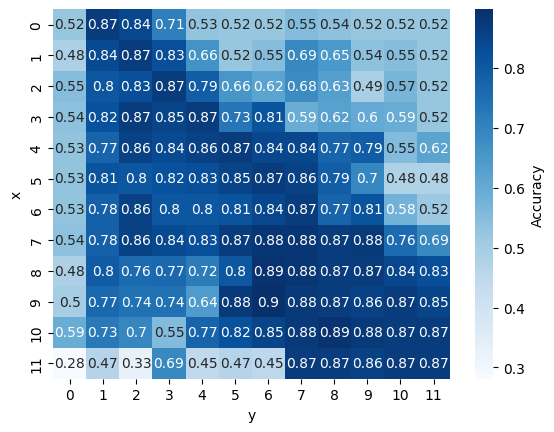

In [8]:
# Plot a heatmap of the accuracy with respect to the layer transitions
# x and y are the layer numbers of the first and last layer of the transition
# the color is the accuracy

import seaborn as sns

sns.heatmap(
    df_big_grid.pivot(index="x", columns="y", values="accuracy"),
    annot=True,
    # fmt=".0%",
    # do not show numbers in the heatmap
    # fmt=".0f",
    cmap="Blues",
    cbar_kws={"label": "Accuracy"},
)

In [9]:
# best score
best = df_big_grid[df_big_grid["accuracy"] == df_big_grid["accuracy"].max()]

best.x.values[0], best.y.values[0]
# get the weave config with the best score
best_weave_config = weave_configs[df_big_grid["accuracy"].idxmax()]

# get the best score using more samples
calculate_score_from_weaving_config_cached(
    best_weave_config,
    # n_examples=4096,
    n_examples=512,
    split="validation",
)

________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=512, split='validation')
calculating score for weaving config md5sum: e628fef824418808d55b90b530c3cf

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/model_merging/model_merging/evaluation.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  return hfds.load_metric("glue", task)
2023-11-28 10:48:06.904444: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpec

_____________________________calculate_score_from_weaving_config - 38.2s, 0.6min


{'accuracy': 0.861328125}

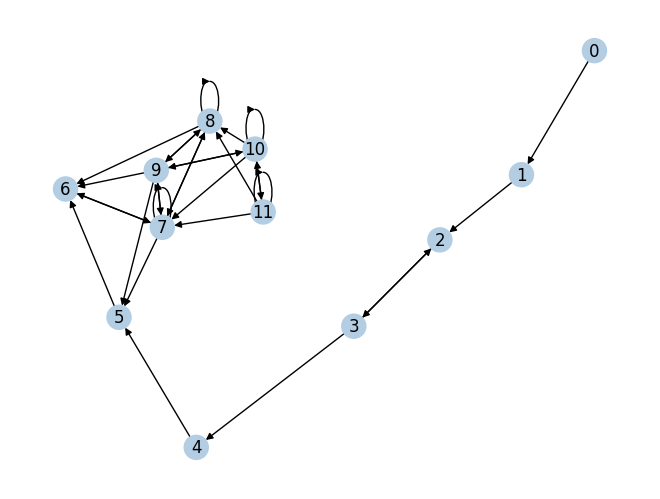

In [26]:
num_layers = get_model_config(model_id)["num_hidden_layers"]

import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(range(num_layers))

weights = (
    df_big_grid.pivot(index="x", columns="y", values="accuracy").fillna(0).to_numpy()
)
max_weight = weights.max()

for x in range(num_layers):
    for y in range(num_layers):
        # if the weight is > 0.7, add the edge
        if weights[x][y] > max_weight - 0.038:
            G.add_edge(x, y, weight=weights[x][y])

# light blue nodes
node_colors = ["#b3cde3"] * num_layers
nx.draw(G, with_labels=True, node_color=node_colors)

In [11]:
# Sample trajectories
import random

random.seed(42)

trajectories_by_length = {}
for length in range(num_layers - 2, num_layers + 7):
    trajectories = []
    while len(trajectories) < 5:
        trajectory = [0]
        while trajectory[-1] != num_layers - 1:
            # Assume uniform distribution over neighbors
            trajectory.append(random.choice(list(G.neighbors(trajectory[-1]))))
        if len(trajectory) == length:
            trajectories.append(trajectory)
    trajectories_by_length[length] = trajectories

print(trajectories_by_length)

{10: [[0, 2, 2, 3, 4, 5, 7, 7, 9, 11], [0, 2, 3, 6, 7, 8, 9, 10, 8, 11], [0, 2, 2, 2, 2, 3, 6, 7, 8, 11], [0, 2, 3, 6, 5, 7, 9, 7, 8, 11], [0, 1, 2, 2, 2, 3, 3, 6, 9, 11]], 11: [[0, 2, 3, 6, 5, 3, 6, 5, 6, 9, 11], [0, 2, 2, 3, 4, 7, 2, 3, 6, 9, 11], [0, 2, 3, 1, 3, 4, 7, 5, 6, 9, 11], [0, 1, 3, 4, 2, 3, 4, 7, 9, 9, 11], [0, 2, 2, 3, 6, 9, 10, 8, 10, 9, 11]], 12: [[0, 2, 3, 6, 2, 3, 3, 6, 9, 10, 10, 11], [0, 1, 2, 2, 2, 3, 4, 7, 8, 9, 10, 11], [0, 1, 3, 3, 1, 3, 6, 2, 3, 6, 9, 11], [0, 2, 3, 2, 3, 6, 9, 7, 8, 10, 9, 11], [0, 2, 3, 1, 1, 1, 3, 3, 6, 6, 9, 11]], 13: [[0, 1, 3, 6, 7, 6, 2, 3, 4, 5, 7, 8, 11], [0, 2, 3, 2, 2, 2, 3, 3, 2, 3, 6, 9, 11], [0, 1, 2, 3, 1, 2, 3, 6, 2, 3, 6, 9, 11], [0, 1, 2, 2, 3, 4, 3, 4, 4, 6, 6, 9, 11], [0, 1, 3, 3, 4, 3, 3, 6, 9, 6, 6, 9, 11]], 14: [[0, 1, 1, 3, 2, 3, 6, 2, 2, 3, 4, 6, 9, 11], [0, 2, 2, 3, 4, 4, 3, 1, 3, 3, 4, 6, 9, 11], [0, 2, 2, 2, 2, 3, 4, 3, 6, 7, 8, 6, 9, 11], [0, 2, 2, 3, 1, 2, 2, 2, 2, 3, 4, 6, 9, 11], [0, 2, 3, 3, 2, 2, 3, 1, 3, 4, 5,

In [12]:
records = []

for length, trajectories in trajectories_by_length.items():
    print(f"Length {length}")
    weave_configs = list(
        transitions_weave_configs_iter(model_id, trajectories=trajectories)
    )

    scores = Parallel(n_jobs=5, return_as="list")(
        delayed(calculate_score_from_weaving_config_cached)(
            weave_config,
            # n_examples=4096,
            n_examples=128,
            split="validation",
        )
        for weave_config in weave_configs
    )
    accuracies = [score["accuracy"] for score in scores]

    for trajectory, accuracy in zip(trajectories, accuracies):
        record = {}
        record["trajectory"] = trajectory
        record["accuracy"] = accuracy
        record["trajectory_length"] = len(trajectory)
        records.append(record)
df_transitions = pd.DataFrame.from_records(records)
df_transitions

Length 10
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward': 0,
                          'classifier_dropout': None,
                          'cross_attention_hidden_size': None,
                          'decoder_start_token_id': None,
                          'diversity_penalty': 0.0,
                          'do_sample': False,
                    ..., n_examples=128, split='validation')
calculating score for weaving config md5sum: c8b76bbd44b8750fb132

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 19.4s, 0.3min
_____________________________calculate_score_from_weaving_config - 22.6s, 0.4min
_____________________________calculate_score_from_weaving_config - 22.9s, 0.4min
_____________________________calculate_score_from_weaving_config - 23.0s, 0.4min
_____________________________calculate_score_from_weaving_config - 23.0s, 0.4min
Length 11
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 21.6s, 0.4min
_____________________________calculate_score_from_weaving_config - 24.6s, 0.4min
_____________________________calculate_score_from_weaving_config - 24.9s, 0.4min
_____________________________calculate_score_from_weaving_config - 24.9s, 0.4min
_____________________________calculate_score_from_weaving_config - 24.9s, 0.4min
Length 12
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-11-28 10:49:16.838755: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 10:49:16.913405: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 10:49:16.917374: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

_____________________________calculate_score_from_weaving_config - 25.0s, 0.4min
_____________________________calculate_score_from_weaving_config - 28.1s, 0.5min
_____________________________calculate_score_from_weaving_config - 28.1s, 0.5min
_____________________________calculate_score_from_weaving_config - 28.1s, 0.5min
_____________________________calculate_score_from_weaving_config - 28.1s, 0.5min
Length 13
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 25.2s, 0.4min
_____________________________calculate_score_from_weaving_config - 28.6s, 0.5min
_____________________________calculate_score_from_weaving_config - 28.7s, 0.5min
_____________________________calculate_score_from_weaving_config - 29.0s, 0.5min
_____________________________calculate_score_from_weaving_config - 29.0s, 0.5min
Length 14
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 28.1s, 0.5min
_____________________________calculate_score_from_weaving_config - 31.0s, 0.5min
_____________________________calculate_score_from_weaving_config - 31.1s, 0.5min
_____________________________calculate_score_from_weaving_config - 31.0s, 0.5min
_____________________________calculate_score_from_weaving_config - 31.2s, 0.5min
Length 15
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

2023-11-28 10:50:47.183385: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 10:50:47.631992: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-28 10:50:47.637727: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

_____________________________calculate_score_from_weaving_config - 30.0s, 0.5min
_____________________________calculate_score_from_weaving_config - 32.7s, 0.5min
_____________________________calculate_score_from_weaving_config - 32.8s, 0.5min
_____________________________calculate_score_from_weaving_config - 32.9s, 0.5min
_____________________________calculate_score_from_weaving_config - 32.9s, 0.5min
Length 16
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 32.1s, 0.5min
_____________________________calculate_score_from_weaving_config - 34.6s, 0.6min
_____________________________calculate_score_from_weaving_config - 34.6s, 0.6min
_____________________________calculate_score_from_weaving_config - 34.9s, 0.6min
_____________________________calculate_score_from_weaving_config - 35.0s, 0.6min
Length 17
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 34.5s, 0.6min
_____________________________calculate_score_from_weaving_config - 36.2s, 0.6min
_____________________________calculate_score_from_weaving_config - 36.7s, 0.6min
_____________________________calculate_score_from_weaving_config - 36.8s, 0.6min
_____________________________calculate_score_from_weaving_config - 37.0s, 0.6min
Length 18
________________________________________________________________________________
[Memory] Calling llm_weaver.calculate_score_from_weaving_config...
calculate_score_from_weaving_config({ 'blank_model_config': { 'add_cross_attention': False,
                          'architectures': ['RobertaForSequenceClassification'],
                          'attention_probs_dropout_prob': 0.1,
                          'bad_words_ids': None,
                          'begin_suppress_tokens': None,
                          'bos_token_id': 0,
                          'chunk_size_feed_forward

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/Users/briancruz/2023-

_____________________________calculate_score_from_weaving_config - 36.8s, 0.6min
_____________________________calculate_score_from_weaving_config - 38.8s, 0.6min
_____________________________calculate_score_from_weaving_config - 38.9s, 0.6min
_____________________________calculate_score_from_weaving_config - 39.1s, 0.7min
_____________________________calculate_score_from_weaving_config - 39.2s, 0.7min


,trajectory,accuracy,trajectory_length
0,"[0, 2, 2, 3, 4, 5, 7, 7, 9, 11]",0.718750,10
1,"[0, 2, 3, 6, 7, 8, 9, 10, 8, 11]",0.679688,10
2,"[0, 2, 2, 2, 2, 3, 6, 7, 8, 11]",0.562500,10
3,"[0, 2, 3, 6, 5, 7, 9, 7, 8, 11]",0.492188,10
4,"[0, 1, 2, 2, 2, 3, 3, 6, 9, 11]",0.546875,10
5,"[0, 2, 3, 6, 5, 3, 6, 5, 6, 9, 11]",0.531250,11
6,"[0, 2, 2, 3, 4, 7, 2, 3, 6, 9, 11]",0.601562,11
7,"[0, 2, 3, 1, 3, 4, 7, 5, 6, 9, 11]",0.781250,11
8,"[0, 1, 3, 4, 2, 3, 4, 7, 9, 9, 11]",0.765625,11
9,"[0, 2, 2, 3, 6, 9, 10, 8, 10, 9, 11]",0.617188,11


<Axes: xlabel='trajectory_length', ylabel='accuracy'>

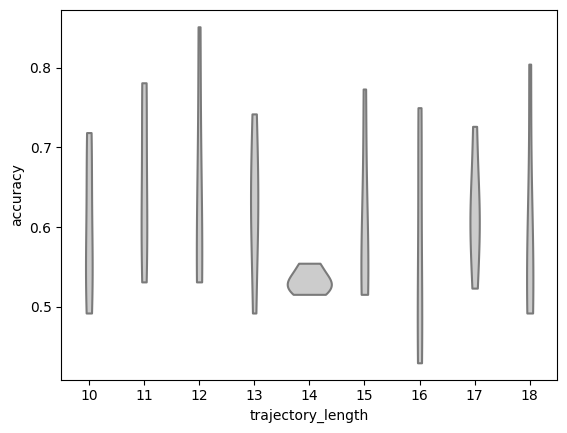

In [13]:
# Show a violin plot of the distribution of accuracies for each trajectory length
sns.violinplot(
    data=df_transitions,
    x="trajectory_length",
    y="accuracy",
    inner=None,
    color=".8",
    cut=0,
)